In [1]:
import pandas as pd
import numpy as np
import decouple
from sklearn.metrics import classification_report, PrecisionRecallDisplay
from openai import OpenAI

config = decouple.AutoConfig(" ")
client = OpenAI(api_key=config("OPENAI_API_KEY"))

EMBEDDING_MODEL = "text-embedding-ada-002"
CSV_DB_NAME = "sentiment_review_embeddings.csv"
THRESHOLD = 0

In [2]:
def get_embedding(text: str) -> list[float]:
    return client.embeddings.create(
        model=EMBEDDING_MODEL,
        input=text,
    ).data[0].embedding

In [3]:
def cosine_similarity(a, b) -> float:
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [4]:
df = pd.read_csv(CSV_DB_NAME)
df["Embedding"] = df.Embedding.apply(eval).apply(np.array)
df["Sentiment"] = df.Score.replace(
    {1: "Negative", 2: "Negative", 4: "Positive", 5: "Positive"}
)
df = df[["Sentiment", "Summ_and_Text", "Embedding"]]
df.head(5)

,Sentiment,Summ_and_Text,Embedding
0,Positive,Title: Good Quality Dog Food; Content: I have ...,"[-0.0003650814469438046, 0.002390077570453286,..."
1,Negative,Title: Not as Advertised; Content: Product arr...,"[-0.010546302422881126, -0.005790255963802338,..."
2,Positive,"Title: ""Delight"" says it all; Content: This is...","[0.0008617175626568496, 0.006630045361816883, ..."
3,Negative,Title: Cough Medicine; Content: If you are loo...,"[0.0109994662925601, 0.016499200835824013, -0...."
4,Positive,Title: Great taffy; Content: Great taffy at a ...,"[-0.01656678318977356, -0.0036593296099454165,..."


In [5]:
def evaluate_classification_labels(labels: list[str], threshold=THRESHOLD)-> None:
    """
    This function will test the accuracy of classification labels, outputting a Precision-Recall curve. This will allow us to test labels such as Positive/Negative, or more complex labels such as 'Positive product review' and 'Negative product review' to see which best match positive/negative review embeddings.
    labels: List of two terms, the first meant to represent a positive review and the second meant to represent a negative review.
    """
    test_label_embeddings = [get_embedding(label) for label in labels]

    def label_score(review_emb, test_label_emb):
        positive_similarity = cosine_similarity(review_emb, test_label_emb[0])
        negative_similarity = cosine_similarity(review_emb, test_label_emb[1])
        return positive_similarity - negative_similarity

    probabilities = df["Embedding"].apply(
        lambda review_emb: label_score(review_emb, test_label_embeddings)
    )
    predictions = probabilities.apply(lambda score: "Positive" if score > threshold else "Negative")

    report = classification_report(df["Sentiment"], predictions)
    print(report)
    display = PrecisionRecallDisplay.from_predictions(
        df["Sentiment"], probabilities, pos_label="Positive"
    )
    display.ax_.set_title("Precision-Recall curve for test classification labels")

              precision    recall  f1-score   support

    Negative       0.88      0.70      0.78        54
    Positive       0.96      0.99      0.97       409

    accuracy                           0.95       463
   macro avg       0.92      0.85      0.88       463
weighted avg       0.95      0.95      0.95       463



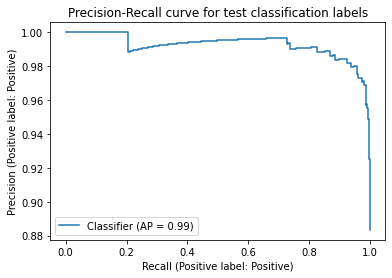

In [6]:
simple_labels = ["Positive", "Negative"]
evaluate_classification_labels(simple_labels)

              precision    recall  f1-score   support

    Negative       0.96      0.83      0.89        54
    Positive       0.98      1.00      0.99       409

    accuracy                           0.98       463
   macro avg       0.97      0.91      0.94       463
weighted avg       0.98      0.98      0.98       463



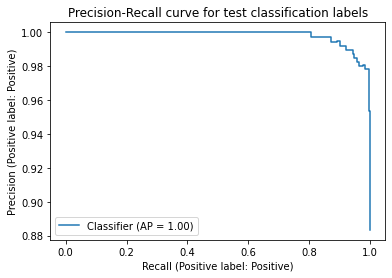

In [7]:
improved_labels = [
    "A product review with positive sentiment",
    "A product review with negative sentiment"
]
evaluate_classification_labels(improved_labels)

In [8]:
def add_prediction_to_df(labels: list[str], threshold=THRESHOLD)-> None:
    """
    This function will add a prediction column to the DataFrame, based on the labels provided.
    """
    label_embeddings = [get_embedding(label) for label in labels]

    def label_score(review_emb, test_label_emb):
        positive_similarity = cosine_similarity(review_emb, test_label_emb[0])
        negative_similarity = cosine_similarity(review_emb, test_label_emb[1])
        return positive_similarity - negative_similarity

    probabilities = df["Embedding"].apply(
        lambda review_emb: label_score(review_emb, label_embeddings)
    )
    df["Prediction"] = probabilities.apply(lambda score: "Positive" if score > threshold else "Negative")

In [9]:
add_prediction_to_df(improved_labels)
pd.set_option('display.max_colwidth', None)
print_df = df.drop(columns=["Embedding"])
print_df.head(30)

,Sentiment,Summ_and_Text,Prediction
0,Positive,Title: Good Quality Dog Food; Content: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.,Positive
1,Negative,"Title: Not as Advertised; Content: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",Negative
2,Positive,"Title: ""Delight"" says it all; Content: This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.",Positive
3,Negative,Title: Cough Medicine; Content: If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The flavor is very medicinal.,Positive
4,Positive,"Title: Great taffy; Content: Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",Positive
5,Positive,"Title: Nice Taffy; Content: I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there was a bit too much red/black licorice-flavored pieces (just not my particular favorites). Between me, my kids, and my husband, this lasted only two weeks! I would recommend this brand of taffy -- it was a delightful treat.",Positive
6,Positive,"Title: Great! Just as good as the expensive brands!; Content: This saltwater taffy had great flavors and was very soft and chewy. Each candy was individually wrapped well. None of the candies were stuck together, which did happen in the expensive version, Fralinger's. Would highly recommend this candy! I served it at a beach-themed party and everyone loved it!",Positive
7,Positive,"Title: Wonderful, tasty taffy; Content: This taffy is so good. It is very soft and chewy. The flavors are amazing. I would definitely recommend you buying it. Very satisfying!!",Positive
8,Positive,Title: Yay Barley; Content: Right now I'm mostly just sprouting this so my cats can eat the grass. They love it. I rotate it around with Wheatgrass and Rye too,Positive
9,Positive,Title: Healthy Dog Food; Content: This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.,Positive
